In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np

# -------------------------------
# 1. Load the dataset
# -------------------------------
datafile = '../data/raw_data/climate_bike/gertjandatafiets.csv'
df = pd.read_csv(datafile)

# -------------------------------
# 2. Inspect the dataset columns
# -------------------------------
print("Columns in the dataset:")
print(df.columns.tolist())

# -------------------------------
# 3. Check for required columns
# -------------------------------
# For calculating MRT we need:
# - Air_Temp: sensor (or air) temperature in °C (to correct long-wave measurements)
# - Short-wave measurements: Qs_in, Qs_out, Qs_left, Qs_right, Qs_front, Qs_back
# - Long-wave measurements: QL_in, QL_out, QL_left, QL_right, QL_front, QL_back

required_cols = ['Air_Temp', 
                 'Qs_in', 'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back',
                 'QL_in', 'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back']

missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError("The following required columns are missing from the dataset: " + str(missing_cols))

# -------------------------------
# 4. Set constants and parameters
# -------------------------------
# Stefan-Boltzmann constant in W/m^2/K^4
sigma = 5.67e-8

# Absorptivity factor for short-wave radiation (commonly ~0.7 for human skin/clothing)
absorptivity = 0.7

# -------------------------------
# 5. Prepare the data for MRT calculation
# -------------------------------
# Convert sensor (air) temperature from °C to Kelvin.
df['T_sensor_K'] = df['Air_Temp'] + 273.15

# Compute the blackbody emission term at the sensor temperature.
# According to the emails, the correction for long-wave radiation is:
#    correction = sigma * T_sensor_K^4
df['L_corr_term'] = sigma * (df['T_sensor_K'] ** 4)

# Define the six directions that are measured.
directions = ['in', 'out', 'left', 'right', 'front', 'back']

# For each direction, combine the shortwave and longwave components.
# The effective radiative flux for a given direction is:
#   E_dir = (QL_dir + L_corr_term) + absorptivity * Qs_dir
# where QL_dir is the raw longwave measurement (which may be negative),
# L_corr_term is the blackbody correction,
# and Qs_dir is the short-wave measurement.
for d in directions:
    Qs_col = 'Qs_' + d
    QL_col = 'QL_' + d
    eff_col = 'E_' + d  # effective flux from this direction
    
    df[eff_col] = (df[QL_col] + df['L_corr_term']) + absorptivity * df[Qs_col]

# Compute the average effective radiative flux from the six directions.
eff_cols = ['E_' + d for d in directions]
df['E_avg'] = df[eff_cols].mean(axis=1)

# -------------------------------
# 6. Calculate Mean Radiant Temperature (MRT)
# -------------------------------
# Using the Stefan-Boltzmann law:
#   sigma * MRT^4 = E_avg   =>   MRT = (E_avg / sigma)^(1/4)
df['MRT_K'] = (df['E_avg'] / sigma) ** 0.25

# Convert MRT to °C if desired:
df['MRT_C'] = df['MRT_K'] - 273.15

# -------------------------------
# 7. Display and (optionally) save the results
# -------------------------------
# Show the first few rows with key columns.
print("\nFirst few rows with MRT values (in Kelvin and °C):")
print(df[['TIMESTAMP', 'Air_Temp', 'MRT_K', 'MRT_C']].head())

# # (Optional) Save the updated DataFrame with the new MRT columns to a new CSV file.
# df.to_csv("../data/raw_data/climate_bike/gertjandatafiets_with_MRT.csv", index=False)

Columns in the dataset:
['TIMESTAMP', 'RECORD', 'GPSData', 'Air_Temp', 'humidity', 'Qs_in', 'Qs_out', 'Qs_left', 'Qs_right', 'Qs_front', 'Qs_back', 'QL_in', 'QL_out', 'QL_left', 'QL_right', 'QL_front', 'QL_back', 'TL_inout', 'TL_leftright', 'TL_front', 'TL_back', 'wheelfreq', 'WindDir', 'WS_ms', 'WSDiag', 'PTemp', 'batt_volt', 'GPSData_time', 'latitude', 'longitude']

First few rows with MRT values (in Kelvin and °C):
         TIMESTAMP  Air_Temp       MRT_K      MRT_C
0  8/23/2023 12:57     25.33  298.723749  25.573749
1  8/23/2023 12:57     25.29  298.737445  25.587445
2  8/23/2023 12:57     25.29  298.770103  25.620103
3  8/23/2023 12:57     25.22  298.703257  25.553257
4  8/23/2023 12:57     25.13  298.613531  25.463531


In [13]:
# Assuming the following have been defined earlier:
# - df: your DataFrame loaded from 'gertjandatafiets.csv'
# - sigma: the Stefan-Boltzmann constant (5.67e-8 W/m²/K⁴)
# - absorptivity: the absorptivity factor for short-wave radiation (e.g., 0.7)
# - 'T_sensor_K' column exists (Air_Temp in Kelvin)
# - 'L_corr_term' has been computed as sigma * (T_sensor_K)**4

# Define the six directions:
directions = ['in', 'out', 'left', 'right', 'front', 'back']

# Compute disaggregated effective radiative flux components for each direction.
for d in directions:
    Qs_col = 'Qs_' + d   # Shortwave measurement, e.g., Qs_in
    QL_col = 'QL_' + d   # Longwave measurement, e.g., QL_in
    
    # Compute the effective longwave component (W/m²):
    # Correct the raw longwave reading using the sensor temperature correction term.
    df['E_long_' + d] = df[QL_col] + df['L_corr_term']
    
    # Compute the effective shortwave component (W/m²):
    # Scale the shortwave measurement by the absorptivity factor.
    df['E_short_' + d] = absorptivity * df[Qs_col]
    
    # Optionally, compute the total effective flux (which is the sum of both components)
    df['E_total_' + d] = df['E_long_' + d] + df['E_short_' + d]

# Display a few rows of the new disaggregated columns
cols_to_show = ['TIMESTAMP'] + \
               ['E_long_' + d for d in directions] + \
               ['E_short_' + d for d in directions] + \
               ['E_total_' + d for d in directions]
print("Disaggregated effective flux values (W/m²) for each direction:")
print(df[cols_to_show].head())
# (Optional) Save the updated DataFrame with the new MRT columns to a new CSV file.
df.to_csv("../data/raw_data/climate_bike/gertjandatafiets_with_MRT.csv", index=False)

Disaggregated effective flux values (W/m²) for each direction:
         TIMESTAMP   E_long_in  E_long_out  E_long_left  E_long_right  \
0  8/23/2023 12:57  429.602629  439.032629   443.468629    447.499629   
1  8/23/2023 12:57  429.361438  438.791438   443.227438    447.373438   
2  8/23/2023 12:57  429.361438  438.901438   443.227438    447.373438   
3  8/23/2023 12:57  428.939587  438.479587   442.805587    446.951587   
4  8/23/2023 12:57  428.397643  438.047643   442.263643    446.525643   

   E_long_front  E_long_back  E_short_in  E_short_out  E_short_left  \
0    440.492629   438.522629      27.090       1.5701        10.465   
1    440.251438   440.691438      27.090       1.5701        10.619   
2    440.251438   443.369438      27.090       1.5701        10.619   
3    439.829587   441.877587      27.244       1.5701        10.619   
4    439.287643   440.667643      27.244       1.5701        10.619   

   E_short_right  E_short_front  E_short_back  E_total_in  E_total_out 

Summary statistics for MRT (Kelvin):
count    33968.000000
mean       305.240072
std          8.630832
min        293.185539
25%        299.020377
50%        302.446884
75%        308.371356
max        339.820191
Name: MRT_K, dtype: float64

Summary statistics for MRT (°C):
count    33968.000000
mean        32.090072
std          8.630832
min         20.035539
25%         25.870377
50%         29.296884
75%         35.221356
max         66.670191
Name: MRT_C, dtype: float64


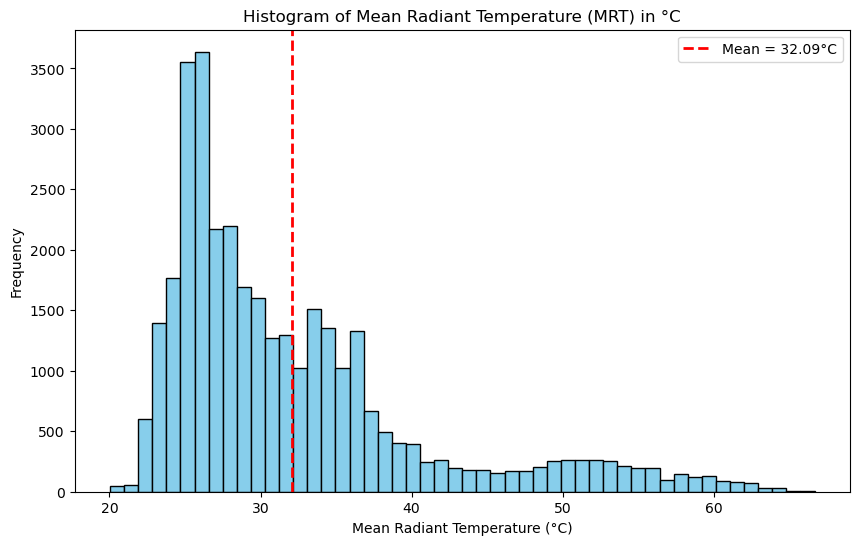

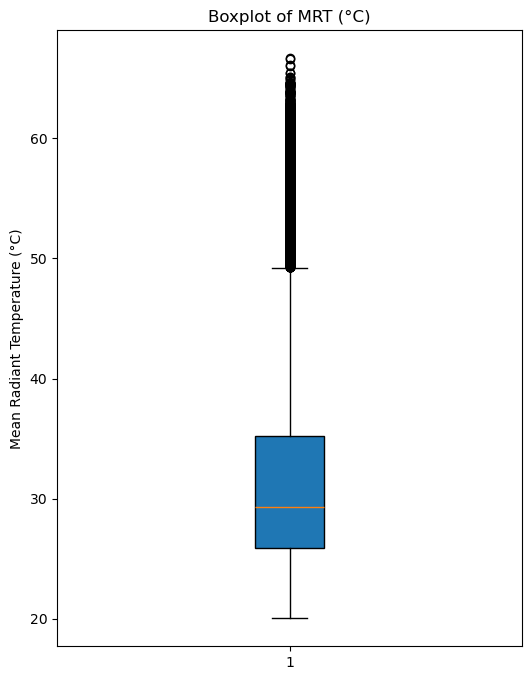

Number of MRT values below 15°C: 0
Number of MRT values above 60°C: 320

Rows with MRT values outside the expected range:
            TIMESTAMP  Air_Temp       MRT_K      MRT_C
1027  8/23/2023 13:14     24.65  333.361431  60.211431
1028  8/23/2023 13:14     24.75  333.915833  60.765833
1029  8/23/2023 13:14     24.77  334.221810  61.071810
1030  8/23/2023 13:14     24.79  333.835162  60.685162
1031  8/23/2023 13:14     24.81  333.357481  60.207481


In [14]:
import matplotlib.pyplot as plt

# -------------------------------
# 1. Summary Statistics
# -------------------------------
print("Summary statistics for MRT (Kelvin):")
print(df['MRT_K'].describe())

print("\nSummary statistics for MRT (°C):")
print(df['MRT_C'].describe())

# -------------------------------
# 2. Histogram of MRT (in °C)
# -------------------------------
plt.figure(figsize=(10, 6))
plt.hist(df['MRT_C'].dropna(), bins=50, color='skyblue', edgecolor='k')
plt.xlabel("Mean Radiant Temperature (°C)")
plt.ylabel("Frequency")
plt.title("Histogram of Mean Radiant Temperature (MRT) in °C")
# Draw a vertical line at the mean value
mean_mrt = df['MRT_C'].mean()
plt.axvline(mean_mrt, color='red', linestyle='dashed', linewidth=2, 
            label=f"Mean = {mean_mrt:.2f}°C")
plt.legend()
plt.show()

# -------------------------------
# 3. Boxplot of MRT (in °C)
# -------------------------------
plt.figure(figsize=(6, 8))
plt.boxplot(df['MRT_C'].dropna(), patch_artist=True, vert=True)
plt.ylabel("Mean Radiant Temperature (°C)")
plt.title("Boxplot of MRT (°C)")
plt.show()

# -------------------------------
# 4. Identify Out-of-Range MRT Values
# -------------------------------
# Define an expected range for MRT in °C. (Adjust these limits as needed.)
expected_lower = 15
expected_upper = 60

n_below = (df['MRT_C'] < expected_lower).sum()
n_above = (df['MRT_C'] > expected_upper).sum()

print(f"Number of MRT values below {expected_lower}°C: {n_below}")
print(f"Number of MRT values above {expected_upper}°C: {n_above}")

# Optionally, list the rows that are out-of-range for further investigation.
outliers = df[(df['MRT_C'] < expected_lower) | (df['MRT_C'] > expected_upper)]
print("\nRows with MRT values outside the expected range:")
print(outliers[['TIMESTAMP', 'Air_Temp', 'MRT_K', 'MRT_C']].head())

In [1]:
#TRANSLATE COORDINATES

In [19]:
import csv
import pandas as pd
import re

df = pd.read_csv('C:/thesis/climate_bike/gertjandatafiets_with_MRT.csv')
print(df)

def extract_gps_data(gps_data):
    # Regular expression for extracting lat and lon
    lat_pattern = re.compile(r'([NS])(\d{2})(\d{5,6})')  # N/S, Degrees, Minutes
    lon_pattern = re.compile(r'([EW])(\d{3})(\d{5,6})')  # E/W, Degrees, Minutes

    # Extract latitude
    lat_match = lat_pattern.search(gps_data)
    if lat_match:
        lat_dir = lat_match.group(1)
        lat_deg = int(lat_match.group(2))  # Degree part
        lat_min = int(lat_match.group(3))  # Minute part
        latitude = lat_deg + (lat_min / 1000000)  # Convert minute to fraction of degree
        if lat_dir == 'S':
            latitude = -latitude  # Negative for South
    else:
        latitude = None

    # Extract longitude
    lon_match = lon_pattern.search(gps_data)
    if lon_match:
        lon_dir = lon_match.group(1)
        lon_deg = int(lon_match.group(2))  # Degree part
        lon_min = int(lon_match.group(3))  # Minute part
        longitude = lon_deg + (lon_min / 1000000)  # Convert minute to fraction of degree
        if lon_dir == 'W':
            longitude = -longitude  # Negative for West
    else:
        longitude = None

    return latitude, longitude

# Apply the function to the 'GPSData' column
df[['Latitude', 'Longitude']] = df['GPSData'].apply(lambda x: pd.Series(extract_gps_data(x)))
df.to_csv('C:/thesis/climate_bike/gertjandatafiets_with_MRT_qgis.csv', index=False)

             TIMESTAMP  RECORD  \
0      8/23/2023 12:57   56706   
1      8/23/2023 12:57   56707   
2      8/23/2023 12:57   56708   
3      8/23/2023 12:57   56709   
4      8/23/2023 12:57   56710   
...                ...     ...   
33963  9/12/2023 15:39   91000   
33964  9/12/2023 15:39   91001   
33965  9/12/2023 15:39   91002   
33966  9/12/2023 15:39   91003   
33967  9/12/2023 15:39   91004   

                                                 GPSData  Air_Temp  humidity  \
0      230823115735N5222666E00452996G004-00018E0000N0...     25.33     48.43   
1      230823115736N5222666E00452996G004-00018E0000N0...     25.29     48.43   
2      230823115737N5222666E00452996G004-00018E0000N0...     25.29     48.46   
3      230823115738N5222666E00452996G004-00018E0000N0...     25.22     48.45   
4      230823115739N5222666E00452996G004-00018E0000N0...     25.13     48.38   
...                                                  ...       ...       ...   
33963  230912143848N5222510E004